In [1]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

try:
  from word2number import w2n
except:
  !pip install word2number
  from word2number import w2n

In [2]:
os.getcwd()

'/content'

In [3]:
data_train = pd.read_csv("train_kaggle.csv")
data_train.head()

<ipython-input-3-e1af3b708662>:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv("train_kaggle.csv")


,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
0,10493832.0,Kelaniya,1209.6,756.0,5292.0,4
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4


In [4]:
data_train["cluster_catgeory"].unique()

array(['4', '1', '99', '2', '5', '3', '6', '6\\', 4, 2, 1, 95, 3, 98, 5,
       6, nan, 100.0, 89.0], dtype=object)

In [5]:
data_train["cluster_catgeory"] = data_train["cluster_catgeory"].replace("6\\",6)
valid_categories = set(str(i) for i in range(1, 7)) | set(i for i in range(1,7))

# Filter categories and convert to integers
def filter_and_convert_category(category):
    if category in valid_categories:
        return int(category)
    return None


data_train = data_train[data_train['cluster_catgeory'].apply(filter_and_convert_category).notnull()]
data_train['cluster_catgeory'] = pd.to_numeric(data_train['cluster_catgeory'], errors='coerce').fillna(0).astype(int)

data_train["cluster_catgeory"].unique()

array([4, 1, 2, 5, 3, 6])

In [6]:
def convert_to_numerical(word_number):
    try:
        numerical_value = float(word_number)
        return numerical_value
    except ValueError:
        try:
            return w2n.word_to_num(word_number)
        except ValueError:
            return None

sales_columns = ["luxury_sales", "fresh_sales", "dry_sales"]
for column in sales_columns:
    data_train[column] = data_train[column].apply(convert_to_numerical)

In [7]:
nan_columns = data_train.columns[data_train.isna().any()].tolist()
nan_columns

['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales', 'dry_sales']

In [8]:
DROP = True
if DROP:
    data_train.dropna(inplace=True)

In [9]:
#set features and target variables
X = data_train.drop(columns = ['cluster_catgeory','Customer_ID'])
y = data_train["cluster_catgeory"]

In [10]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
outlets = X_train["outlet_city"].unique().tolist()
outlets

['Nuwara Eliya',
 'Jaffna',
 'Kaduwela',
 'Gampaha',
 'Dehiwala-Mount Lavinia',
 'Trincomalee',
 'Homagama',
 'Panadura',
 'Katunayake',
 'Batticaloa',
 'Kotte',
 'Colombo',
 'Negombo',
 'Wattala',
 'Kalmunai',
 'Kandy',
 'Peliyagoda',
 'Moratuwa',
 'Galle',
 'Kelaniya']

In [12]:
city_encoding = dict()

count = 0
for city in outlets:
  city_encoding[city] = count
  count+=1

# Apply custom encoding
X_train['city_encoded'] = X_train['outlet_city'].map(city_encoding)
X_test['city_encoded'] = X_test['outlet_city'].map(city_encoding)

# Drop the original 'outlet_city' column
X_train.drop(columns=['outlet_city'], inplace=True)
X_test.drop(columns=['outlet_city'], inplace=True)

# SVM

In [13]:
################### FOR SUPPORT VECTOR MACHINE ########################
X_train_final = X_train
X_test_final = X_test

X_train.head()

,luxury_sales,fresh_sales,dry_sales,city_encoded
186980,726.50,4794.90,1307.70,0
715975,3467.70,12714.90,2504.45,1
342796,2702.70,2866.50,2702.70,2
420915,2695.28,3080.32,12898.84,3
558880,2376.43,9645.51,1957.06,3


In [14]:
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

#Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# Convert scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_final.columns)

#visualize traing data
X_train_scaled.head()

,luxury_sales,fresh_sales,dry_sales,city_encoded
0,-1.190272,0.109627,-0.988107,-1.657100
1,1.538024,2.484745,-0.637143,-1.482657
2,0.776625,-0.468678,-0.579003,-1.308215
3,0.769240,-0.404556,2.411161,-1.133772
4,0.451891,1.564270,-0.797673,-1.133772


In [15]:
X_train_scaled.to_csv("train_scaled.csv")
X_test_scaled.to_csv("test_scaled.csv")

In [16]:
if not DROP:
    # Impute NaN values with the mean of each column
    imputer = SimpleImputer(strategy='mean')
    X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
    X_test_scaled_imputed = imputer.transform(X_test_scaled)

    # Convert back to DataFrame (optional)
    X_train_imputed = pd.DataFrame(X_train_scaled_imputed, columns=X_train.columns)
    X_test_imputed = pd.DataFrame(X_test_scaled_imputed, columns=X_test.columns)

    X_train_imputed.head()

In [17]:
#SVM Model Training
SVM = True
if SVM:
  svm_classifier = SVC(kernel='linear', C=1.0)
  svm_classifier.fit(X_train_scaled, y_train)

In [18]:
if SVM:
  y_pred = svm_classifier.predict(X_test_scaled)
  print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00     37914
           2       1.00      0.99      0.99     30902
           3       0.65      0.60      0.62      9735
           4       1.00      0.99      1.00     34409
           5       0.55      0.60      0.57      7925
           6       0.99      1.00      1.00     33925

    accuracy                           0.95    154810
   macro avg       0.86      0.86      0.86    154810
weighted avg       0.95      0.95      0.95    154810



In [19]:
import pickle
if SVM:
  with open ("classifier.pkl","wb+") as f:
    pickle.dump(svm_classifier, f)
  with open ("scaler.pkl","wb+") as f:
    pickle.dump(scaler, f)

In [20]:
data_test = pd.read_csv("test_kaggle.csv")

def convert_to_numerical(word_number):
    try:
        numerical_value = float(word_number)
        return numerical_value
    except ValueError:
        try:
            return w2n.word_to_num(word_number)
        except ValueError:
            return None

sales_columns = ["luxury_sales", "fresh_sales", "dry_sales"]
for column in sales_columns:
    data_test[column] = data_test[column].apply(convert_to_numerical)

city_encoding2 = dict()

for key in city_encoding:
  city_encoding2[key.upper()]=city_encoding[key]

data_test['city_encoded'] = data_test['outlet_city'].apply(lambda x:x.upper()).map(city_encoding2)

In [21]:
nan_columns = data_test.columns[data_test.isna().any()].tolist()
nan_columns

['city_encoded']

In [22]:
# Drop the original 'outlet_city' column
data_test.drop(columns=['outlet_city','Customer_ID'], inplace=True)

data_test.columns = data_test.columns.astype(str)

data_test_scaled = scaler.transform(data_test)

# Convert scaled arrays back to DataFrames
data_test_scaled = pd.DataFrame(data_test_scaled, columns=data_test.columns)

imputer = SimpleImputer(strategy='mean')
data_test_scaled_imputed = imputer.fit_transform(data_test_scaled)

# Convert back to DataFrame
data_test_imputed = pd.DataFrame(data_test_scaled_imputed, columns=data_test.columns)

data_test_imputed.head()

,luxury_sales,fresh_sales,dry_sales,city_encoded
0,0.760502,-0.254108,2.305046,-0.087116
1,-0.203877,-0.555694,1.398736,-0.087116
2,-1.063332,-0.955775,0.153917,-0.087116
3,-0.282943,-0.632366,1.350670,-0.087116
4,-0.879153,-0.872877,0.222353,-0.087116


In [23]:
y_results = svm_classifier.predict(data_test_imputed)

In [24]:
for_id = pd.read_csv("test_kaggle.csv")

for_id["cluster_catgeory"] = y_results

for_id.drop(columns=['outlet_city','luxury_sales','fresh_sales','dry_sales'], inplace=True)
for_id.head()

,Customer_ID,cluster_catgeory
0,33574,1
1,10089,1
2,38329,1
3,11376,1
4,12410,1


In [25]:
for_id.to_csv("results_svm.csv",index=False)

In [26]:
y_result = pd.DataFrame(y_results)
y_result

,0
0,1
1,1
2,1
3,1
4,1
...,...
40744,3
40745,5
40746,3
40747,3


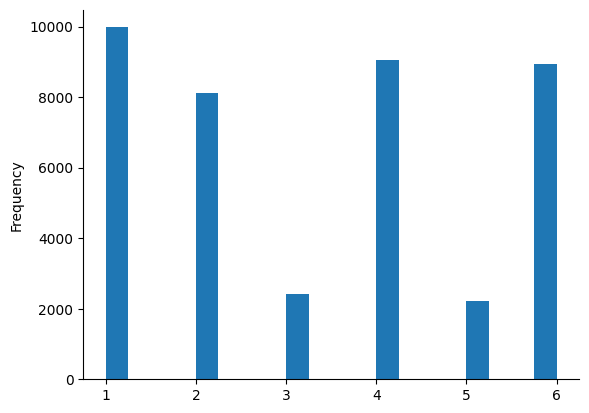

In [27]:
from matplotlib import pyplot as plt
y_result[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Random Forest

In [28]:
RF = True
if RF:
  clf = RandomForestClassifier(n_estimators=100, random_state=42)
  clf.fit(X_train, y_train)

In [29]:
if RF:
  y_pred = clf.predict(X_test)

In [30]:
if RF:
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  print(f"Accuracy: {accuracy}")
  print("Classification Report:")
  print(report)

Accuracy: 0.9979458691299011
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37914
           2       1.00      1.00      1.00     30902
           3       1.00      1.00      1.00      9735
           4       1.00      1.00      1.00     34409
           5       1.00      1.00      1.00      7925
           6       1.00      1.00      1.00     33925

    accuracy                           1.00    154810
   macro avg       1.00      1.00      1.00    154810
weighted avg       1.00      1.00      1.00    154810



In [31]:
data_test = pd.read_csv("test_kaggle.csv")

def convert_to_numerical(word_number):
    try:
        numerical_value = float(word_number)
        return numerical_value
    except ValueError:
        try:
            return w2n.word_to_num(word_number)
        except ValueError:
            return None

sales_columns = ["luxury_sales", "fresh_sales", "dry_sales"]
for column in sales_columns:
    data_test[column] = data_test[column].apply(convert_to_numerical)

city_encoding2 = dict()

for key in city_encoding:
  city_encoding2[key.upper()]=city_encoding[key]

data_test['city_encoded'] = data_test['outlet_city'].apply(lambda x:x.upper()).map(city_encoding2)

In [32]:
# Drop the original 'outlet_city' column
data_test.drop(columns=['outlet_city','Customer_ID'], inplace=True)

In [33]:
imputer = SimpleImputer(strategy='mean')
data_test_scaled_imputed = imputer.fit_transform(data_test_scaled)

# Convert back to DataFrame
data_test_imputed = pd.DataFrame(data_test_scaled_imputed, columns=data_test.columns)

data_test_imputed.head()

,luxury_sales,fresh_sales,dry_sales,city_encoded
0,0.760502,-0.254108,2.305046,-0.087116
1,-0.203877,-0.555694,1.398736,-0.087116
2,-1.063332,-0.955775,0.153917,-0.087116
3,-0.282943,-0.632366,1.350670,-0.087116
4,-0.879153,-0.872877,0.222353,-0.087116


In [34]:
y_results = clf.predict(data_test_imputed)

In [35]:
for_id = pd.read_csv("test_kaggle.csv")

for_id["cluster_catgeory"] = y_results

for_id.drop(columns=['outlet_city','luxury_sales','fresh_sales','dry_sales'], inplace=True)
for_id.head()

,Customer_ID,cluster_catgeory
0,33574,6
1,10089,6
2,38329,6
3,11376,6
4,12410,6


In [36]:
for_id.to_csv("results_rf.csv",index=False)

In [37]:
y_result = pd.DataFrame(y_results)
y_result

,0
0,6
1,6
2,6
3,6
4,6
...,...
40744,6
40745,6
40746,6
40747,6


#Multi-layer Perceptron

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Validate the model
y_test_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print(f"Validation Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Validation Accuracy: 0.9997739164136684
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37914
           2       1.00      1.00      1.00     30902
           3       1.00      1.00      1.00      9735
           4       1.00      1.00      1.00     34409
           5       1.00      1.00      1.00      7925
           6       1.00      1.00      1.00     33925

    accuracy                           1.00    154810
   macro avg       1.00      1.00      1.00    154810
weighted avg       1.00      1.00      1.00    154810



In [42]:
data_test = pd.read_csv("test_kaggle.csv")

def convert_to_numerical(word_number):
    try:
        numerical_value = float(word_number)
        return numerical_value
    except ValueError:
        try:
            return w2n.word_to_num(word_number)
        except ValueError:
            return None

sales_columns = ["luxury_sales", "fresh_sales", "dry_sales"]
for column in sales_columns:
    data_test[column] = data_test[column].apply(convert_to_numerical)

city_encoding2 = dict()

for key in city_encoding:
  city_encoding2[key.upper()]=city_encoding[key]

def pass_name(city_name):
    standardized_name = city_name.strip().upper()
    # Handle specific known cases
    if standardized_name == 'TRINCOMALE' or standardized_name=="ANURADHAPURA" or standardized_name=="MADAWACHIYA":
        standardized_name = 'TRINCOMALEE'
    return standardized_name

data_test['city_encoded'] = data_test['outlet_city'].apply(pass_name).map(city_encoding2)

In [43]:
# Drop the original 'outlet_city' column
data_test.drop(columns=['outlet_city','Customer_ID'], inplace=True)
data_test_scaled = scaler.transform(data_test)

imputer = SimpleImputer(strategy='mean')
data_test_scaled_imputed = imputer.fit_transform(data_test_scaled)

# Convert back to DataFrame
data_test_imputed = pd.DataFrame(data_test_scaled_imputed, columns=data_test.columns)

data_test_imputed.head()

,luxury_sales,fresh_sales,dry_sales,city_encoded
0,0.760502,-0.254108,2.305046,-0.087116
1,-0.203877,-0.555694,1.398736,-0.087116
2,-1.063332,-0.955775,0.153917,-0.087116
3,-0.282943,-0.632366,1.350670,-0.087116
4,-0.879153,-0.872877,0.222353,-0.087116


In [44]:
y_results = mlp.predict(data_test_imputed)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [45]:
for_id = pd.read_csv("test_kaggle.csv")

for_id["cluster_catgeory"] = y_results

for_id.drop(columns=['outlet_city','luxury_sales','fresh_sales','dry_sales'], inplace=True)
for_id.head()

,Customer_ID,cluster_catgeory
0,33574,1
1,10089,1
2,38329,1
3,11376,1
4,12410,1


In [46]:
y_result = pd.DataFrame(y_results)
y_result

,0
0,1
1,1
2,1
3,1
4,1
...,...
40744,5
40745,5
40746,5
40747,5


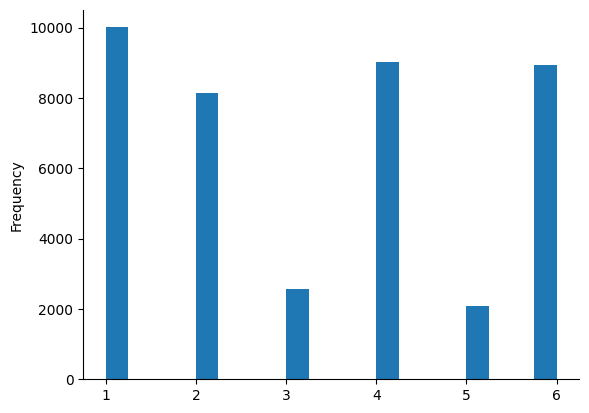

In [47]:
from matplotlib import pyplot as plt
y_result[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [48]:
for_id.to_csv("results_nn.csv",index=False)